In [13]:
# Data is taken from:
# "MNIST in CSV" by Dariel Dato-on
# PyTorch does have the data available internally, but using this dataset lets us get
# more experience with importing and using our own data.

# Packages:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader, TensorDataset, random_split

# Should we use a GPU?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
dataset = np.loadtxt('mnist_train.csv', delimiter=',', skiprows = 1, dtype = np.int64)

In [3]:
dataset.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [15]:
num_samples = dataset.shape[0] #gets the rows int the dataset by taking the first element of the shape tuple
num_channels = 1 # Grayscale has 1 channel, no color
image_size = 28 # 28 x 28 pixel image 

# Convert the data to tensors
training_labels = torch.from_numpy(dataset[:,0])

training_features = torch.from_numpy(dataset[:,1:]).float()
training_features = training_features.reshape([num_samples, num_channels, image_size, image_size])#matching to what a CNN expects

# Create a pytorch dataset
training_data_set = TensorDataset(training_features, training_labels)


In [16]:
# Create a data loader
training_data_loader = DataLoader(training_data_set, 
                                  batch_size=64, 
                                  shuffle=True, 
                                  num_workers=4,
                                  pin_memory=True)

Batch size: 64, Total number of batches: 937.5
Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


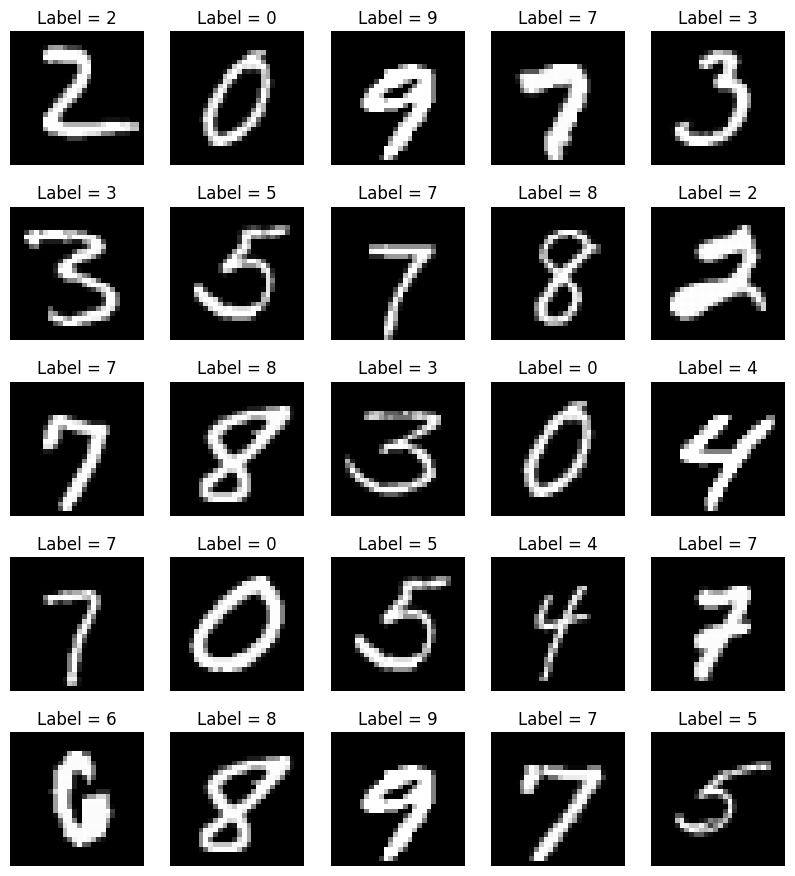

In [17]:
# Explore the data loader
# Gets the first batch of images and labels
batch_features, batch_labels = next(iter(training_data_loader))

batch_size = batch_labels.size()[0]

print(f"Batch size: {batch_size}, Total number of batches: {num_samples/batch_size}")
print(f"Feature batch shape: {batch_features.size()}")
print(f"Labels batch shape: {batch_labels.size()}")

figure = plt.figure(figsize=(10, 11))
cols, rows = 5, 5

for i in range(1, cols * rows + 1):
    index = torch.randint(batch_size, size=(1,)).item()
    figure.add_subplot(rows, cols, i)
    plt.imshow(batch_features[index,0,:,:], cmap="gray")
    plt.title(f"Label = {batch_labels[index]}")
    plt.axis("off")
    
plt.show()

In [18]:
def create_neural_network():
    # Create our network
    neural_network = torch.nn.Sequential(
        torch.nn.Conv2d(1, 16, 5, 1, 2),# 1 input channel, 16 filters, 5x5 kernel, stride of 1, padding of 2
        torch.nn.ReLU(), #activation function
        torch.nn.MaxPool2d(2), #2x2 max pooling

        torch.nn.Conv2d(16, 32, 5, 1, 2), # 16 input channels, 32 filters, 5x5 kernel, stride of 1, padding of 2
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),

        torch.nn.Flatten(),
        torch.nn.Linear(32 * 7 * 7, 10),
        # Why isn't there a softmax here? Look into how CrossEntropyLoss() works to find out more.
    )

    # Send the network to whatever device you are using
    neural_network.to(device)
    return neural_network

In [23]:
def compute_accuracy(model, data_loader):
    correct_samples = 0
    total_samples = 0
    model.eval()

    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += y.size(0)
        correct_samples += (predicted == y).sum().item()

    return correct_samples / total_samples


In [26]:
def train_model(learning_rate: float, batch_size: int):
    num_epochs = 5

    # Splitting data into training and validation sets
    train_len = int(0.8 * len(training_data_set))
    valid_len = len(training_data_set) - train_len
    train_dataset, valid_dataset = random_split(training_data_set, [train_len, valid_len])

    # Creating DataLoaders for train and valid sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

    total_num_batches = len(train_loader)
    
    neural_network = create_neural_network()
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.ASGD(neural_network.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_prediction = neural_network(X_batch)
            loss = loss_function(y_prediction, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    accuracy = compute_accuracy(neural_network, valid_loader)
    
    return accuracy

# Grid Search
param_grid = {'learning_rate': [0.1, 0.01, 0.001], 'batch_size': [32, 64, 128]}
results = {}  # a new dictionary to hold accuracy results
best_accuracy = 0.0
best_params = None

for lr in param_grid['learning_rate']:
    for batch in param_grid['batch_size']:
        print(f"Training with learning_rate={lr} and batch_size={batch}")
        accuracy = train_model(lr, batch)
        # Store the accuracy result for this pair of hyperparameters
        results[(lr, batch)] = accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'learning_rate': lr, 'batch_size': batch}

print("Best params:", best_params)
print("Best accuracy:", best_accuracy)


Training with learning_rate=0.1 and batch_size=32


Training with learning_rate=0.1 and batch_size=64
Training with learning_rate=0.1 and batch_size=128
Training with learning_rate=0.01 and batch_size=32
Training with learning_rate=0.01 and batch_size=64
Training with learning_rate=0.01 and batch_size=128
Training with learning_rate=0.001 and batch_size=32
Training with learning_rate=0.001 and batch_size=64
Training with learning_rate=0.001 and batch_size=128
Best params: {'learning_rate': 0.001, 'batch_size': 32}
Best accuracy: 0.98125


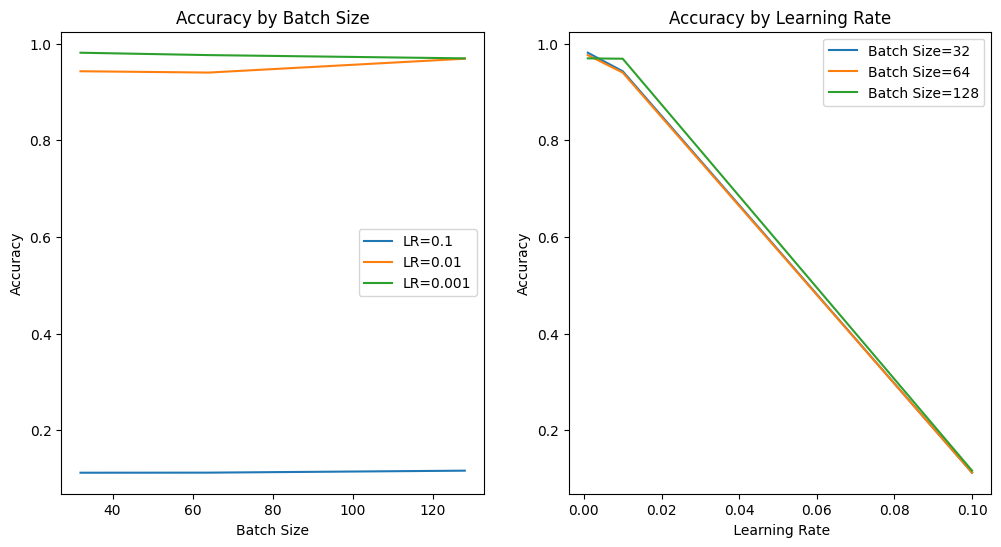

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

for lr in param_grid['learning_rate']:
    # plot the batch sizes and corresponding accuracies for this learning rate
    batch_sizes = param_grid['batch_size']
    accuracies = [results[(lr, batch)] for batch in batch_sizes]
    axes[0].plot(batch_sizes, accuracies, label=f'LR={lr}')

for batch in param_grid['batch_size']:
    # plot the learning rates and corresponding accuracies for this batch size
    learning_rates = param_grid['learning_rate']
    accuracies = [results[(lr, batch)] for lr in learning_rates]
    axes[1].plot(learning_rates, accuracies, label=f'Batch Size={batch}')

# Final touches on the plots
axes[0].set_xlabel('Batch Size')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy by Batch Size')
axes[0].legend()

axes[1].set_xlabel(' Learning Rate')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy by Learning Rate')
axes[1].legend()

plt.show()

In [13]:
# Validation:
validation = np.loadtxt('mnist_test.csv', delimiter=',', skiprows = 1, dtype = np.int64)

num_validation_samples = validation.shape[0]

# Convert the data to tensors
validation_labels = torch.from_numpy(validation[:,0])
validation_labels = validation_labels.to(device)

validation_features = torch.from_numpy(validation[:,1:]).float()
validation_features = validation_features.reshape([num_validation_samples, num_channels, image_size, image_size])
validation_features = validation_features.to(device)

Accuracy 94.58%


542 misclassifications


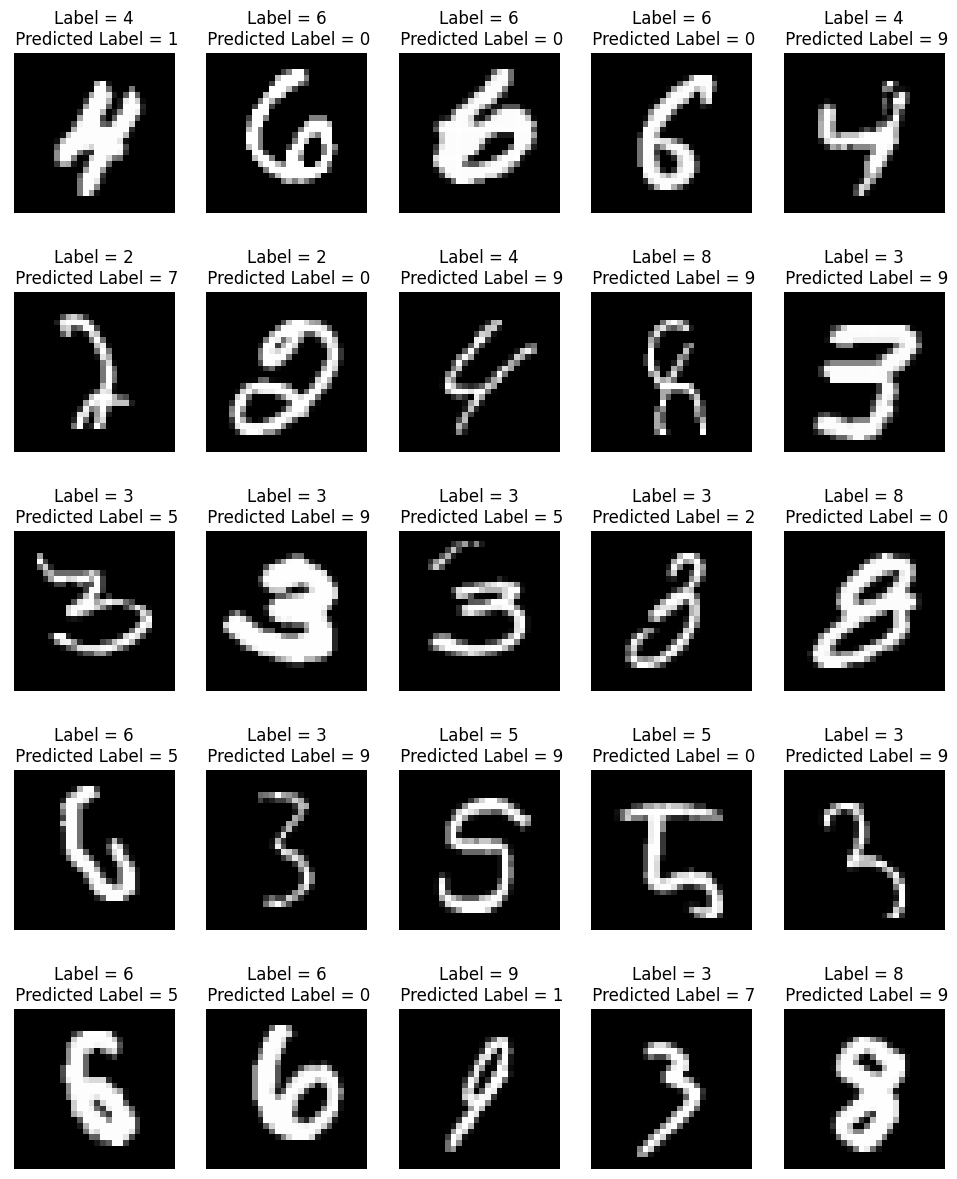

In [15]:
# Print a few of the failed classifications to see if there is anything interesting:
# First send the data to the CPU:
validation_labels = validation_labels.to('cpu')
validation_features = validation_features.to('cpu')
predicted_labels = predicted_labels.to('cpu')

# Continue what we were doing - Add your own comments:
failed_matches = validation_labels != predicted_labels
failed_indices = np.where(failed_matches)[0]

print(f"{failed_indices.shape[0]} misclassifications")

figure = plt.figure(figsize=(12, 15))
cols, rows = 5, 5

for i in range(1, cols * rows + 1):
    index = np.random.choice(failed_indices)
    figure.add_subplot(rows, cols, i)
    plt.imshow(validation_features[index,0,:,:], cmap="gray")
    plt.title(f"Label = {validation_labels[index]}\n Predicted Label = {predicted_labels[index]}")
    plt.axis("off")
    
plt.show()

In [ ]:
# # If you are curious about how to choose the optimal number of workers then run and analyze this script:
import multiprocessing as mp

for num_workers in range(0, mp.cpu_count(), 2):  
    train_loader = DataLoader(training_data_set, shuffle=True, num_workers=num_workers, batch_size=64, pin_memory=True)

    start = time.time()
    for epoch in range(1, 3):
        for batch_num, (X_batch, y_batch) in enumerate(train_loader):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            pass

    elapsed_time = time.time() - start
    
    print(f"{elapsed_time:.2f} seconds with {num_workers} workers")